5. Model Development
Treat as a multiclass classification problem (trend_label = rising/stable/declining).
Baseline Models:
Logistic Regression (multinomial)
Random Forest
Advanced Models:
XGBoost
LightGBM
Approach:
Split data (70% train / 15% validation / 15% test).
Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning.
Evaluate with stratified sampling to preserve class balance.
6. Model Evaluation
Metrics:
Accuracy
Precision / Recall / F1-score (especially for “rising” class)
Confusion matrix for misclassification patterns
ROC-AUC per class
Interpretation Tools:
SHAP or LIME for feature importance visualization.
Identify key drivers behind rising trends (e.g., hashtags, music type, posting time).


### Preprocessing and looking at the data 

In [1]:
# upload the data file -- GOING TO DO THIS LATER MAYBE IN JUPYTER BC IT TAKES FOREVER
# from google.colab import files

# uploaded = files.upload()

In [ ]:
# look at the head of the data
# df = uploaded

# df.head()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("preprocessed_project_data.csv")

In [3]:
df.head()

,trend_label,platform_x,creator_tier,title_len,text_richness,like_rate,comment_rate,share_rate,like_rate_log,comment_rate_log,...,traffic_source_profile,traffic_source_search,traffic_source_share,device_brand_google,device_brand_huawei,device_brand_oppo,device_brand_other,device_brand_samsung,device_brand_xiaomi,trend_label_encoded
0,stable,youtube,nano,-0.687259,-0.687259,0.307328,0.114627,-0.079759,0.358807,0.137483,...,False,True,False,False,False,False,False,True,False,3.957002
1,stable,youtube,micro,-0.687259,-0.687259,-1.020190,0.722159,0.610931,-1.042626,0.737066,...,False,False,False,False,False,False,False,False,False,3.957002
2,stable,tiktok,micro,-0.687259,-0.687259,-0.867849,1.308960,0.061196,-0.870892,1.298584,...,False,True,False,True,False,False,False,False,False,3.957002
3,rising,tiktok,mid,-0.687259,-0.687259,-0.034182,-0.450611,2.312503,0.017565,-0.438065,...,False,False,False,False,True,False,False,False,False,0.568808
4,rising,tiktok,mid,-0.687259,-0.687259,-0.034182,-0.450611,2.312503,0.017565,-0.438065,...,False,False,False,False,True,False,False,False,False,0.568808


In [4]:
df.columns

Index(['trend_label', 'platform_x', 'creator_tier', 'title_len',
       'text_richness', 'like_rate', 'comment_rate', 'share_rate',
       'like_rate_log', 'comment_rate_log', 'share_rate_log', 'views_per_day',
       'likes_per_day', 'rel_like', 'rel_share', 'rel_combo',
       'like_hashtag_interaction', 'share_hashtag_interaction', 'platform_cat',
       'region_cat', 'language_cat', 'category_cat', 'traffic_source_cat',
       'device_brand_cat', 'creator_tier_cat', 'richness_traffic_interaction',
       'country_x', 'top_hashtag', 'country_y', 'platform_y', 'year_month',
       'n_videos', 'views', 'avg_er', 'avg_velocity_y', 'like_rate_zscore',
       'comment_rate_zscore', 'share_rate_zscore', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_MENA', 'region_Oceania',
       'language_de', 'language_en', 'language_es', 'language_fr',
       'language_hi', 'language_it', 'language_ja', 'language_ko',
       'language_pt', 'language_ru', 'language_tr', 'category_Com

In [5]:
df['year_month'].value_counts()

year_month
2025-03    271372
2025-07    208872
2025-08    208382
2025-06    184852
2025-05    180588
2025-04    179754
2025-02    133872
Unknown     32402
Name: count, dtype: int64

In [6]:
# Check for columns with a high percentage of 'UNKNOWN' values

if 'df' not in locals():
    print("Error: DataFrame 'df' not found. Please ensure your data is loaded into a DataFrame named 'df'.")
else:
    unknown_counts = {}
    total_rows = len(df)

    # Define a threshold for what constitutes 'lots' of UNKNOWN values (e.g., 20%)
    threshold = 0.20 # 20% of the rows

    for column in df.columns:
        # Count 'UNKNOWN' (case-insensitive for robustness)
        unknown_count = df[column].astype(str).str.upper().eq('UNKNOWN').sum()
        if unknown_count > 0:
            unknown_percentage = (unknown_count / total_rows) * 100
            if unknown_percentage >= (threshold * 100):
                unknown_counts[column] = {
                    'count': unknown_count,
                    'percentage': f"{unknown_percentage:.2f}%"
                }

    if unknown_counts:
        print("Columns with a high percentage of 'UNKNOWN' values (exceeding " + f"{threshold*100:.0f}%" + "):")
        for col, data in unknown_counts.items():
            print(f"  - Column '{col}': {data['count']} 'UNKNOWN' values ({data['percentage']})")
        print("Consider handling these 'UNKNOWN' values, e.g., by imputation or dropping the columns/rows.")
    else:
        print("No columns found with a high percentage of 'UNKNOWN' values (exceeding " + f"{threshold*100:.0f}%" + ").")


Columns with a high percentage of 'UNKNOWN' values (exceeding 20%):
  - Column 'country_x': 1400094 'UNKNOWN' values (100.00%)
  - Column 'top_hashtag': 1400094 'UNKNOWN' values (100.00%)
Consider handling these 'UNKNOWN' values, e.g., by imputation or dropping the columns/rows.


In [7]:
# Drop leakage columns
leak_cols = ['trend_label_encoded', 'rel_combo', 'likes_per_day', 'share_rate_log', 'views', 'views_per_day', 'like_rate', 'comment_rate', 'share_rate', 'like_rate_log', 'comment_rate_log', 'rel_like', 'rel_share', 'avg_velocity_y', 'avg_er', 'richness_traffic_interaction', 'country_x', 'country_y', 'top_hashtag', 'top_hashtag', 'like_rate_zscore', 'comment_rate_zscore', 'share_rate_zscore', 'traffic_source_feed', 'traffic_source_hashtag', 'traffic_source_profile', 'traffic_source_search','traffic_source_share', 'platform_x', 'platform_y', 'creator_tier', 'title_len','text_richness', 'traffic_source_cat', 'device_brand_cat', 'creator_tier_cat', 'like_hashtag_interaction', 'share_hashtag_interaction' ]
df = df.drop(columns=[c for c in leak_cols if c in df.columns])

df = df.dropna(subset=['trend_label'])
df = df.reset_index(drop=True)

# Convert and clean date
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce')
df = df.dropna(subset=['year_month'])

print(f"Data Shape: {df.shape}")
print("Unique Months:", sorted(df['year_month'].unique()))

Data Shape: (1367692, 39)
Unique Months: [Timestamp('2025-02-01 00:00:00'), Timestamp('2025-03-01 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-05-01 00:00:00'), Timestamp('2025-06-01 00:00:00'), Timestamp('2025-07-01 00:00:00'), Timestamp('2025-08-01 00:00:00')]


## Logistic Regression

In [40]:
# split by month
target = 'trend_label'
months = sorted(df['year_month'].unique())

train_months = months[:3]
test_months  = months[3:]

df_train = df[df['year_month'].isin(train_months)]
df_test  = df[df['year_month'].isin(test_months)]

# grab features and target
y_train_full = df_train[target]
X_train_full = df_train.drop(columns=[target])

y_test = df_test[target]
X_test = df_test.drop(columns=[target])

#preprocess the features 
def preprocess_features(X):
    X = X.copy()
    
    # numerical columns
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
    
    # convert boolean columns to int
    bool_cols = X.select_dtypes(include=['bool']).columns
    X[bool_cols] = X[bool_cols].astype(int)
    
    # one-hot encode categorical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if categorical_cols:
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    # convert datetime to int64
    datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
    X[datetime_cols] = X[datetime_cols].astype('int64')
    
    return X, numerical_cols

# Process train and test features
X_train_full, numerical_cols = preprocess_features(X_train_full)
X_test, _ = preprocess_features(X_test)

# make sure that the columns match
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# create a validation set 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,          # 20% of training data → validation
    random_state=42,
    stratify=y_train_full
)

# scale numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols]   = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols]  = scaler.transform(X_test[numerical_cols])

# logistic regression
log_reg_3 = LogisticRegression(random_state=42, max_iter=1000)

print("Logistic Regression 3 model initialized and data prepared.")


Logistic Regression 3 model initialized and data prepared.


In [41]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# fit the logistic regression model
log_reg_3.fit(X_train, y_train)
print("Model training completed.")

# predict on validation set
y_pred_test = log_reg_3.predict(X_test)

print("Validation prediction completed.")

# precision, recall, f1
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_test,
    y_pred_test,
    average='binary',
    pos_label='rising'   # change if needed
)

print(f"Precision (rising): {precision:.4f}")
print(f"Recall (rising): {recall:.4f}")
print(f"F1-score (rising): {f1_score:.4f}")

# accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Accuracy: {accuracy:.4f}")


Model training completed.
Validation prediction completed.
Precision (rising): 0.6548
Recall (rising): 1.0000
F1-score (rising): 0.7914
Accuracy: 0.5556


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

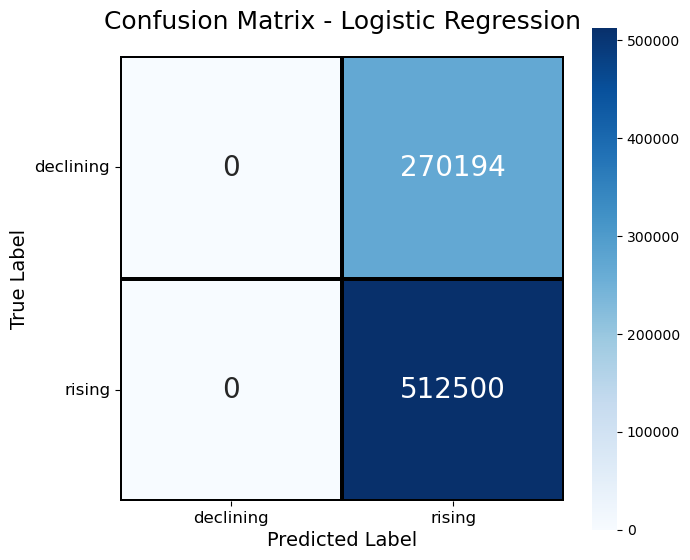

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix
cm = confusion_matrix(
    y_test,
    y_pred_test,
    labels=['declining', 'rising']   # keep consistent order
)

# confusion matrix
plt.figure(figsize=(7, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=1.5,
    linecolor='black',
    cbar=True,
    square=True,
    annot_kws={"size": 20}
)

# Titles and labels
plt.title("Confusion Matrix - Logistic Regression", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Tick labels must match the label order above
ax.set_xticklabels(['declining', 'rising'], fontsize=12)
ax.set_yticklabels(['declining', 'rising'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# create random forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

print("Random Forest model initialized.")

# fit on training data
rf_model.fit(X_train, y_train)
print("Random Forest training completed.")

# predict on validation data
y_pred_test_rf = rf_model.predict(X_test)
print("Random Forest validation prediction completed.")

# precision, recall, f1
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_test,
    y_pred_test_rf,
    average='binary',
    pos_label='rising'
)

print(f"RF Precision (rising): {precision:.4f}")
print(f"RF Recall (rising): {recall:.4f}")
print(f"RF F1-score (rising): {f1_score:.4f}")

# accuracy
accuracy = accuracy_score(y_test, y_pred_test_rf)
print(f"RF Accuracy: {accuracy:.4f}")


Random Forest model initialized.
Random Forest training completed.
Random Forest validation prediction completed.
RF Precision (rising): 0.9165
RF Recall (rising): 0.4071
RF F1-score (rising): 0.5638
RF Accuracy: 0.5875


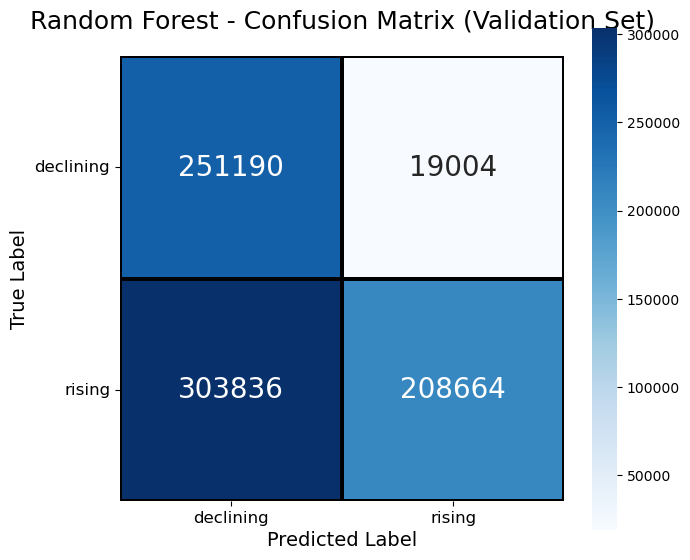

In [46]:
cm = confusion_matrix(
    y_test,
    y_pred_test_rf,
    labels=['declining', 'rising']
)

plt.figure(figsize=(7, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=1.5,
    linecolor='black',
    cbar=True,
    square=True,
    annot_kws={"size": 20}
)

plt.title("Random Forest - Confusion Matrix", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

ax.set_xticklabels(['declining', 'rising'], fontsize=12)
ax.set_yticklabels(['declining', 'rising'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


In [64]:
import pandas as pd

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

fi

,feature,importance
5,n_videos,0.588862
0,platform_cat,0.172199
4,year_month,0.088241
2,language_cat,0.016135
36,device_brand_samsung,0.012478
1,region_cat,0.011891
3,category_cat,0.009695
37,device_brand_xiaomi,0.008083
33,device_brand_huawei,0.007269
35,device_brand_other,0.006757


## XGBoost

In [48]:
!pip install xgboost

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
print("Starting RandomizedSearchCV...")
random_search.fit(X_train, y_train_enc)  # <-- Changed here
print("RandomizedSearchCV completed.")
print(f"\nBest hyperparameters:\n{random_search.best_params_}")
print(f"Best F1-weighted score (CV): {random_search.best_score_:.4f}")

Starting RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x1078adbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x105b5dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  F

RandomizedSearchCV completed.

Best hyperparameters:
{'colsample_bytree': np.float64(0.6550083776583973), 'gamma': np.float64(0.17053317552512925), 'learning_rate': np.float64(0.032694704248117816), 'max_depth': 9, 'n_estimators': 514, 'reg_alpha': np.float64(0.877339353380981), 'reg_lambda': np.float64(0.2579416277151556), 'subsample': np.float64(0.8639936184136716)}
Best F1-weighted score (CV): 0.9661


In [60]:
# Get best model and predict
best_model = random_search.best_estimator_
y_pred_encoded = best_model.predict(X_test)

# Decode predictions for evaluation
y_val_labels = y_test  # Already in original format ('declining'/'rising')
y_pred_labels = le.inverse_transform(y_pred_encoded)  # Convert predictions back
class_names = le.classes_

In [65]:
# Evaluation

# USE TEST SET FOR XGBOOST BECAUSE VAL SET USED TO TUNE HYPERPARAMETERS
print("\n--- XGBoost Test Set Evaluation ---")
# precision, recall, f1
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_test,
    y_pred_labels,
    average='binary',
    pos_label='rising'
)

print(f"XGBoost Precision (rising): {precision:.4f}")
print(f"XGBoost Recall (rising): {recall:.4f}")
print(f"XGBoost F1-score (rising): {f1_score:.4f}")

# accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"XGBoost Accuracy: {accuracy:.4f}")


--- XGBoost Test Set Evaluation ---
XGBoost Precision (rising): 0.8395
XGBoost Recall (rising): 0.6229
XGBoost F1-score (rising): 0.7151
XGBoost Accuracy: 0.6751


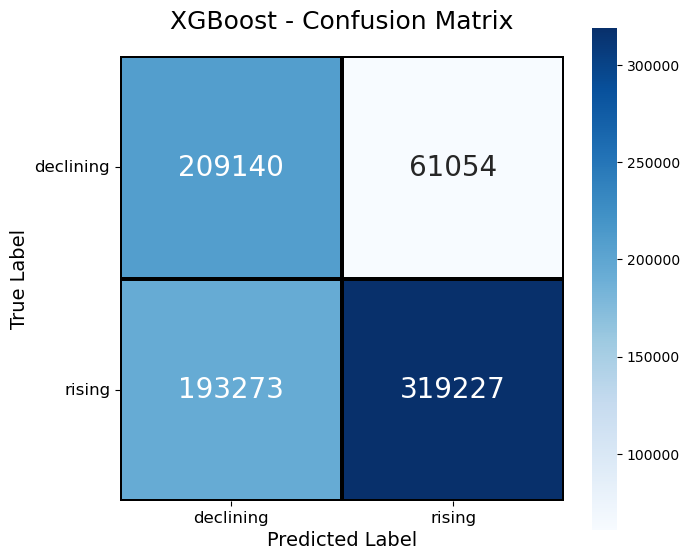

In [63]:
cm = confusion_matrix(
    y_test,
    y_pred_labels,
    labels=['declining', 'rising']
)

plt.figure(figsize=(7, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=1.5,
    linecolor='black',
    cbar=True,
    square=True,
    annot_kws={"size": 20}
)

plt.title("XGBoost - Confusion Matrix", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

ax.set_xticklabels(['declining', 'rising'], fontsize=12)
ax.set_yticklabels(['declining', 'rising'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

## Feature Importance for Random Forest and XG Boost


--- Random Forest Feature Importance ---
Top 15 features for Random Forest:
                         Feature  Importance
3                       n_videos    0.303112
41            platform_x_youtube    0.168102
39          device_brand_samsung    0.031292
10                   language_en    0.023906
2   richness_traffic_interaction    0.021888
4                region_Americas    0.021548
44             creator_tier_nano    0.020803
6                  region_Europe    0.020367
42            creator_tier_micro    0.020124
5                    region_Asia    0.018888
40           device_brand_xiaomi    0.017026
37             device_brand_oppo    0.014410
36           device_brand_huawei    0.014295
13                   language_hi    0.012945
38            device_brand_other    0.012426


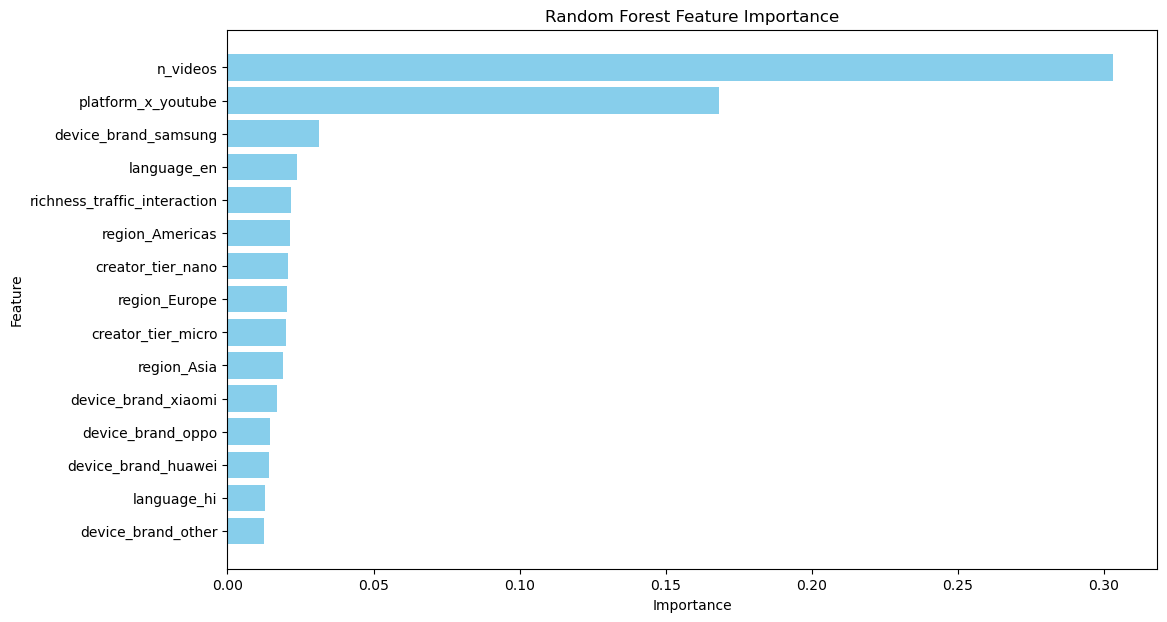

In [37]:
# --- Feature Importance for Random Forest ---
print("\n--- Random Forest Feature Importance ---")
if 'rf_model_2' in globals() and 'X_tree_train' in globals():
    feature_importances_rf = rf_model_2.feature_importances_
    feature_names = X_tree_train.columns

    # Create a DataFrame for better visualization
    rf_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances_rf
    })
    rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

    # Display top N features
    top_n_rf = 15 # You can adjust this number
    print(f"Top {top_n_rf} features for Random Forest:")
    print(rf_importance_df.head(top_n_rf))

    # Plotting feature importance
    plt.figure(figsize=(12, 7))
    plt.barh(rf_importance_df['Feature'].head(top_n_rf), rf_importance_df['Importance'].head(top_n_rf), color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Random Forest Feature Importance')
    plt.gca().invert_yaxis() # To have the most important feature at the top
    plt.show()
else:
    print("Random Forest model (rf_model) or X_train not found. Please run the Random Forest training cell first.")


--- XGBoost Feature Importance ---
Top 15 features for XGBoost:
                         Feature  Importance
3                       n_videos    0.433048
41            platform_x_youtube    0.137846
42            creator_tier_micro    0.015460
43              creator_tier_mid    0.015052
44             creator_tier_nano    0.015014
32        traffic_source_profile    0.011418
34          traffic_source_share    0.011321
31        traffic_source_hashtag    0.010949
27               category_Sports    0.010759
23               category_Gaming    0.010269
14                   language_it    0.010249
2   richness_traffic_interaction    0.010171
30           traffic_source_feed    0.010129
19                   language_tr    0.009911
8                 region_Oceania    0.009909


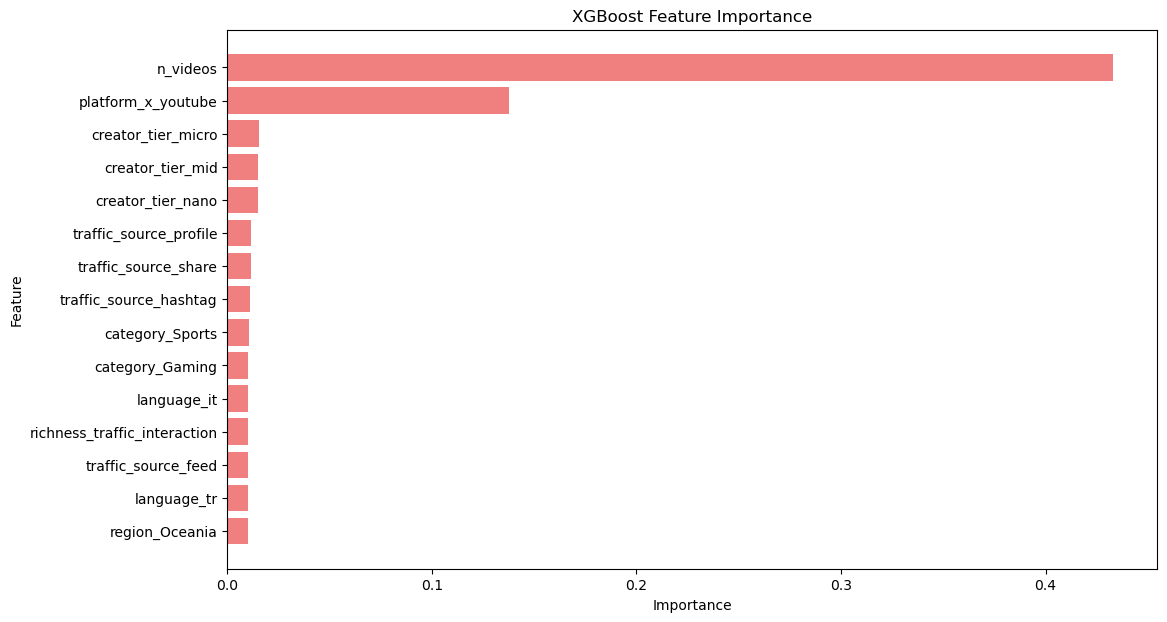

In [38]:
# --- Feature Importance for XGBoost ---
print("\n--- XGBoost Feature Importance ---")
if 'best_model' in globals() and 'X_train' in globals():
    # XGBoost has a get_score method, but feature_importances_ is generally available too
    # If using get_score, feature names might need to be explicitly passed if they aren't default f0, f1, etc.
    feature_importances_xgb = best_model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame for better visualization
    xgb_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances_xgb
    })
    xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)

    # Display top N features
    top_n_xgb = 15 # You can adjust this number
    print(f"Top {top_n_xgb} features for XGBoost:")
    print(xgb_importance_df.head(top_n_xgb))

    # Plotting feature importance
    plt.figure(figsize=(12, 7))
    plt.barh(xgb_importance_df['Feature'].head(top_n_xgb), xgb_importance_df['Importance'].head(top_n_xgb), color='lightcoral')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importance')
    plt.gca().invert_yaxis() # To have the most important feature at the top
    plt.show()
else:
    print("XGBoost model (xgb_model) or X_train not found. Please run the XGBoost training cell first.")

In [6]:
sample_cols = ['platform_x', 'creator_tier', 'title_len', 'text_richness', 'richness_traffic_interaction',
           'n_videos', 'region_Americas', 'region_Asia', 'region_Europe', 'region_MENA',
           'region_Oceania', 'language_de', 'language_en', 'language_es', 'language_fr',
           'language_hi', 'language_it', 'language_ja', 'language_ko',
           'language_pt', 'language_ru', 'language_tr', 'category_Comedy',
           'category_Education', 'category_Food', 'category_Gaming',
           'category_Lifestyle', 'category_Music', 'category_News',
           'category_Sports', 'category_Tech', 'category_Travel',
           'traffic_source_feed', 'traffic_source_hashtag',
           'traffic_source_profile', 'traffic_source_search',
           'traffic_source_share', 'device_brand_google', 'device_brand_huawei',
           'device_brand_oppo', 'device_brand_other', 'device_brand_samsung',
           'device_brand_xiaomi', 'trend_label']

In [7]:
sample = df[sample_cols]

# sample.to_csv('sample.csv', index=False)